# TODO 리스트 관리 및 툴 구현

본 튜토리얼에서는 **LangChain**과 **LangGraph**를 활용하여 Deep Agent의 상태 관리와 TODO 리스트 기반의 작업 플로우 설계 방법을 다룹니다. 장기 작업 관리 전략과 커스텀 State 및 툴(`write_todos`, `read_todos`) 
구현 과정을 단계별로 설명합니다.

![](assets/agent_header_todo.png)

**🏆 핵심 내용**

*   **TODO 리스트 기반 플래닝**: 장기 작업 수행 시 에이전트의 목표 집중 유도
*   **DeepAgentState 설계**: `messages`, `todos`, `files` 등 커스텀 State 구조 및 Reducer 정의
*   **TODO 관리 툴 구현**: `write_todos`, `read_todos` 툴의 구현 및 활용
*   **에이전트 그래프 구축**: `create_agent`를 활용한 에이전트 설계 및 시각화
*   **실습**: 사용자 요청 처리 및 웹 검색 연동 전체 플로우 실습

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Deep-Agent-Tutorial


## TODO 리스트를 활용한 에이전트 플래닝

복잡한 장기 작업 수행 시, 에이전트는 **TODO List**를 핵심 내비게이션 도구로 활용합니다. 이는 **Context Rot** 및 **Mission Drift**를 방지하고 목표를 일관성 있게 유지하는 데 필수적입니다.

*   **활용 사례**: [Claude Code Plan Mode](https://www.anthropic.com/engineering/claude-code-best-practices), [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) 등
*   **구조**: `content`(작업 설명)와 `status`(pending, in_progress, completed)로 구성
*   **효과**: 툴 호출 증가에 따른 컨텍스트 손실 방지 및 작업 집중력 유지

> **Tip**: TODO 리스트의 지속적인 갱신(Recitation)은 에이전트의 장기 기억력을 보완합니다.

**참고 자료**
*   [Claude Code Plan Mode](https://www.anthropic.com/engineering/claude-code-best-practices)
*   [Context Rot 개념](https://research.trychroma.com/context-rot)
*   [Manus 컨텍스트 엔지니어링](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)

## State 설계

워크플로우 컨텍스트 저장을 위한 `DeepAgentState` 구조를 정의합니다. `AgentState`를 상속받아 다음 세 가지 주요 요소를 포함합니다.

*   **`messages`**: 대화 기록 (`add_messages` reducer 사용)
*   **`todos`**: 작업 리스트 (`Todo` 객체 리스트, 전체 덮어쓰기 방식)
*   **`files`**: 가상 파일 시스템 (파일명-내용 매핑, `file_reducer` 사용)

In [2]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict
from langchain.agents import AgentState


# 복잡한 작업 플로우의 진행 상황 추적을 위한 TODO 항목 구조 정의
class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


# 두 파일 딕셔너리 병합, 오른쪽 값이 우선 적용되는 가상 파일 시스템 업데이트용 reducer 함수
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


# LangGraph AgentState 상속, TODO 리스트와 가상 파일 시스템 포함한 확장 state 구조 정의
class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    # 작업 플래닝 및 진행 상황 추적을 위한 Todo 리스트 필드
    todos: NotRequired[list[Todo]]
    # 파일명과 내용 매핑, file_reducer로 병합되는 가상 파일 시스템 필드
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

**필드 상세 설명**

1. `todos: NotRequired[list[Todo]]`

- 목적: 작업 플래닝과 진행 상황 추적
- 타입: `NotRequired[list[Todo]]`
  - `NotRequired`: 필드가 없어도 됨
  - `list[Todo]`: `Todo` 객체 리스트
- 동작: 전체 덮어쓰기 방식으로 업데이트
- 사용 예시:
  ```python
  state = {
      "messages": [...],
      "todos": [
          {"content": "작업 1 완료", "status": "completed"},
          {"content": "작업 2 진행", "status": "in_progress"}
      ]
  }
  ```

2. `files: Annotated[NotRequired[dict[str, str]], file_reducer]`

- 목적: 가상 파일 시스템 (파일명-내용 매핑)
- 타입: `Annotated[NotRequired[dict[str, str]], file_reducer]`
  - `NotRequired`: 필드가 없어도 됨
  - `dict[str, str]`: 파일명(키)과 내용(값) 매핑
  - `Annotated`: 메타데이터로 `file_reducer` 지정
- 동작: `file_reducer`로 병합 (오른쪽 값 우선)
- `file_reducer` 동작:
  - 기존 파일(`left`)과 새 파일(`right`) 병합
  - `right`의 값이 `left`를 덮어씀
  - 증분 업데이트 지원

## 도구 설계

### TODO 관리 툴

에이전트가 목표를 관리하기 위한 `write_todos` 및 `read_todos` 툴의 역할은 다음과 같습니다.

*   **`write_todos`**: 전체 TODO 리스트를 재작성하여 State 갱신 (작업 추가/수정/상태 변경)
*   **`read_todos`**: 현재 State의 TODO 리스트 조회
*   **운영 방식**: 개별 항목 수정이 아닌 리스트 전체 갱신을 통해 유연한 목표 관리 지원

In [3]:
# 프롬프트 출력 함수 show_prompt 사용 목적, LLM 프롬프트 예시 시각화
from utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

# WRITE_TODOS_DESCRIPTION 프롬프트 내용을 시각적으로 출력, LLM 툴 설명 확인 용도
show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create and manage structured task lists for tracking progress through complex workflows.                       │
│                                                                                                                 │
│  ## When to Use                                                                                                 │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions unless directed otherwise                                                  │
│                                                                                                                 │
│  ## Structure                                                                                                   │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│                                                                                                                 │
│  ## Best Practices                                                                                              │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│                                                                                                                 │
│  ## Progress Updates                                                                                            │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│                                                                                                                 │
│  ## Parameters                                                                                                  │
│  - todos: List of TODO items with content and status fields                                                     │
│                                                                                                                 │
│  ## Returns                                                                                                     │
│  Updates agent state with new todo list.                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

복잡한 워크플로우 진행 상황 추적을 위한 구조화된 작업 목록 생성 및 관리

**사용 시점**

- 조율이 필요한 다단계 또는 복잡한 작업
- 사용자가 여러 작업을 제공하거나 명시적으로 TODO 목록을 요청한 경우
- 단순 작업에는 사용 지양 (별도 지시가 없는 한)

**구조**

- 여러 TODO 객체(content, status, id)를 포함하는 단일 목록 유지
- 명확하고 실행 가능한 내용 설명 사용
- status 값: pending, in_progress, completed

**모범 사례**

- 동시에 in_progress 상태는 하나의 작업만 허용
- 작업 완료 즉시 completed로 표시
- 변경 시 항상 전체 업데이트된 목록 전송
- 목록 집중도 유지를 위해 불필요한 항목 정리

**진행 상황 업데이트**

- 작업 상태 변경 또는 내용 수정 시 TodoWrite 재호출
- 실시간 진행 상황 반영, 완료 건 일괄 처리 금지
- 차단 발생 시 in_progress 유지 및 차단 사유 설명하는 새 작업 추가

**파라미터**

- todos: content 및 status 필드를 포함한 TODO 항목 목록

**반환값**

- 새 TODO 목록으로 에이전트 상태 업데이트

### `write_todos` 및 `read_todos` 툴 구현

`InjectedState`와 `Command`를 활용하여 실제 툴을 구현합니다.

*   **`write_todos`**: 입력받은 TODO 리스트로 State를 업데이트하고, 변경 내역을 `ToolMessage`로 기록
*   **`read_todos`**: State에서 현재 TODO 리스트를 읽어 포맷팅된 문자열을 `ToolMessage`로 반환 (Command 사용)

In [4]:
from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import DeepAgentState, Todo


# write_todos 툴 정의, LLM이 전달한 TODO 리스트를 state에 저장 및 메시지 기록
@tool(description=WRITE_TODOS_DESCRIPTION, parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    # TODO 리스트와 메시지 업데이트를 위한 Command 객체 반환
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

`parse_docstring=True`로 설정하면,

1. 함수의 docstring을 읽습니다
2. Google Style 형식의 파라미터 설명을 찾습니다
3. 각 파라미터의 타입과 설명을 추출합니다
4. 추출된 정보를 schema에 포함시킵니다

### 예시

```python
def example_function(name: str, age: int):
    """
    사용자 정보를 처리합니다.

    Args:
        name: 사용자의 이름
        age: 사용자의 나이
    """
    pass
```

위와 같은 docstring이 있을 때, `parse_docstring=True`로 설정하면 `name`과 `age` 파라미터의 설명이 자동으로 schema에 포함됩니다.

In [5]:
# read_todos 툴 정의, 현재 state의 TODO 리스트를 읽어 포맷된 문자열로 반환
@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    # state에서 todos 리스트 추출, 없으면 빈 리스트 반환
    todos = state.get("todos", [])
    if not todos:
        # TODO 리스트가 비어 있을 때 안내 메시지 반환
        return "현재 목록에 있는 모든 항목이 아닙니다."

    # 현재 TODO 리스트를 번호, 이모지, 상태와 함께 포맷팅하여 문자열로 생성
    result = "현재 TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"

    # 최종 포맷된 TODO 리스트 문자열 반환
    return result.strip()

In [6]:
# read_todos 툴 정의, 현재 state의 TODO 리스트를 읽어 포맷된 문자열로 반환
@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Command to update agent state with ToolMessage containing formatted TODO list
    """
    # state에서 todos 리스트 추출, 없으면 빈 리스트 반환
    todos = state.get("todos", [])
    if not todos:
        # TODO 리스트가 비어 있을 때 안내 메시지 반환
        message_content = "현재 목록에 있는 모든 항목이 아닙니다."
    else:
        # 현재 TODO 리스트를 번호, 이모지, 상태와 함께 포맷팅하여 문자열로 생성
        result = "현재 TODO List:\n"
        for i, todo in enumerate(todos, 1):
            status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
            emoji = status_emoji.get(todo["status"], "❓")
            result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"
        message_content = result.strip()

    # Command 객체로 래핑하여 ToolMessage와 함께 반환
    return Command(
        update={
            "messages": [ToolMessage(message_content, tool_call_id=tool_call_id)],
        }
    )

## Graph 구축

`create_agent`를 사용하여 TODO 리스트를 적극적으로 활용하는 에이전트를 구축합니다.

*   **설계 목표**: 작업 완료 시마다 TODO 리스트를 재확인(Recitation)하는 전략 적용
*   **기대 효과**: 장기 작업 시 목표 이탈 방지 및 일관성 유지

In [7]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

# TODO 리스트 사용 지침 프롬프트 시각화, 에이전트 툴 활용 시 참고 목적
show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

사용자 요청 기반 작업 절차:

1. 사용자 요청 시작 시 write_todos 도구를 사용하여 TODO 생성 (도구 설명 참조)
2. TODO 완료 후 read_todos로 TODO 목록 확인 및 계획 재검토
3. 완료 작업과 TODO 검토
4. 작업 완료 표시 후 다음 TODO 진행
5. 모든 TODO 완료 시까지 반복

중요: 모든 사용자 요청에 대해 위 지침에 따른 TODO 기반 리서치 계획 수립 및 리서치 수행 필수

중요: TODO 수 최소화를 위해 리서치 작업은 단일 TODO로 배치 처리 권장

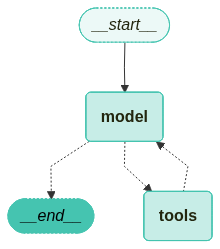

In [9]:
import os
from IPython.display import display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.agents import create_agent
from utils import format_messages

from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tools import read_todos, write_todos

from langchain_teddynote.graphs import visualize_graph


# 웹 검색 툴 모킹: 실제 검색 대신 고정된 결과 반환
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """

    # 웹 검색 결과 모킹, 실제 검색 대신 고정된 결과 반환
    search_result = """모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로,
AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다.
이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 수 있도록 합니다.
본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써 AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다."""

    return search_result


# LLM 모델 초기화
model = init_chat_model(model="anthropic:claude-sonnet-4-5", temperature=0.0)
# 에이전트에 사용할 툴 리스트 정의, TODO 관리 및 웹 검색 포함
tools = [write_todos, web_search, read_todos]

# 단일 웹 검색 호출만 허용하는 간단한 리서치 지침 문자열
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question. Answer in Korean."""

# create_agent 함수로 에이전트 생성, 시스템 프롬프트에 TODO 사용 지침 및 리서치 지침 포함
agent = create_agent(
    model,
    tools,
    system_prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# 에이전트 그래프 시각화, Mermaid PNG 포맷으로 출력
visualize_graph(agent)

## 실행 및 테스트

초기 `todos`가 없는 상태에서 사용자 요청을 처리하는 플로우를 검증합니다.

1.  **초기화**: 빈 TODO 리스트로 시작
2.  **플래닝**: 사용자 요청 분석 후 첫 TODO 리스트 생성
3.  **실행**: `web_search` 등 툴을 활용하여 작업 수행 및 TODO 상태 업데이트

In [10]:
from langchain_teddynote.messages import invoke_graph

inputs = {
    "messages": [
        {
            "role": "user",
            "content": "Model Context Protocol (MCP) 에 대해서 짧고 간결하게 설명해 주세요.",
        }
    ]
}

invoke_graph(agent, inputs)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

[{'id': 'toolu_01RpKhn9WR2H4LRZG39MTxhn', 'input': {'todos': [{'content': 'MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기', 'status': 'in_progress'}]}, 'name': 'write_todos', 'type': 'tool_use'}, {'id': 'toolu_01Upw7m1pkaP7jMtswqf9LxS', 'input': {'query': 'Model Context Protocol MCP'}, 'name': 'web_search', 'type': 'tool_use'}]
Tool Calls:
  write_todos (toolu_01RpKhn9WR2H4LRZG39MTxhn)
 Call ID: toolu_01RpKhn9WR2H4LRZG39MTxhn
  Args:
    todos: [{'content': 'MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기', 'status': 'in_progress'}]
  web_search (toolu_01Upw7m1pkaP7jMtswqf9LxS)
 Call ID: toolu_01Upw7m1pkaP7jMtswqf9LxS
  Args:
    query: Model Context Protocol MCP

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{'content': 'MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기', 'status': 'in_progress'}
==================

In [11]:
# 실행
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Model Context Protocol (MCP) 에 대해서 짧고 간결하게 설명해 주세요.",
            }
        ],
        "todos": [],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP) 에 대해서 짧고 간결하게 설명해 주세요.                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기",                            │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01HvhKBm2phrMViEszVwpiYR                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP"                                                                         │
│ }                                                                                                               │
│    ID: toolu_01DPncXxnijvDFFJVNQ18Ke5                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기', 'status': │
│ 'in_progress'}]                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로,                                        │
│ AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다.                │
│ 이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 │
│ 수 있도록 합니다.                                                                                               │
│ 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써 AI 어시스턴트를 외부 서비스에 연결하는 과정을      │
│ 단순화합니다.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01HnypGxFXx57XKWN2S2sEAd                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. 🔄 MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기 (in_progress)                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기",                            │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01YQybfiNztTqEyYXmWCM63L                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'MCP(Model Context Protocol)에 대해 웹 검색하고 간결하게 설명하기', 'status': │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) 간단 설명                                                                       │
│                                                                                                                 │
│ **MCP(Model Context Protocol)**는 Anthropic이 개발한 **개방형 표준 프로토콜**입니다.                            │
│                                                                                                                 │
│ ### 핵심 기능:                                                                                                  │
│ - **AI 모델과 외부 시스템 연결**: 데이터베이스, 도구, 서비스 등을 AI와 통합                                     │
│ - **표준화된 통신 계층**: 다양한 데이터 소스에 일관된 방식으로 접근                                             │
│ - **통합 언어 제공**: 데이터 교환을 위한 공통 규격 제시                                                         │
│                                                                                                                 │
│ ### 한마디로:                                                                                                   │
│ AI 어시스턴트가 외부 서비스와 쉽게 소통할 수 있도록 만든 **표준 연결 규약**입니다. 마치 USB처럼 다양한 시스템을 │
│ AI에 꽂아 사용할 수 있게 해주는 프로토콜이라고 생각하시면 됩니다.                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**실행 결과 추적 (LangSmith)**

아래 링크에서 에이전트의 실행 흐름과 State 변화를 상세히 확인할 수 있습니다.

*   [LangChain Smith Trace](https://smith.langchain.com/public/96c5c085-80d8-4b63-b5c9-f4b31b10fae3/r)